# Chapter 4 - Regression and Prediction

Import required Python packages

In [4]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

In [5]:
%matplotlib inline

## Simple Linear Regression

## The Regression Equation

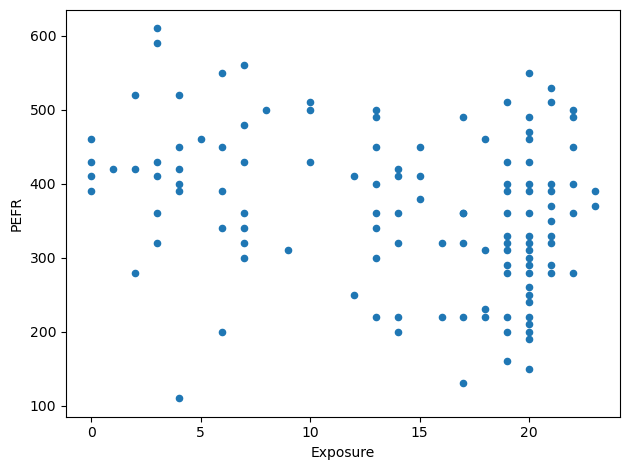

In [8]:
lung = pd.read_csv(r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\practical-statistics-for-data-scientists-master\practical-statistics-for-data-scientists-master\data\LungDisease.csv")
lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

In _Python_, we can use `LinearRegression` from the `scikit-learn` package. (the stats models package has a linear regression implementation that is more similar to R (sm.OLS); we will use it later in this chapter):

In [10]:
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Intercept: {model.intercept_:.3f}')
print(f'Coefficient Exposure: {model.coef_[0]:.3f}')

Intercept: 424.583
Coefficient Exposure: -4.185


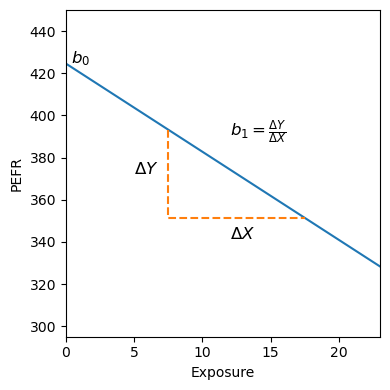

In [11]:
fig, ax = plt.subplots(figsize=(4,4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.plot((0, 23), model.predict(pd.DataFrame({'Exposure': [0, 23]})))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x = pd.DataFrame({'Exposure': [7.5, 17.5]})
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
plt.show()

## Fitted Values and Residuals

With `scikit-learn’s LinearRegression` model, we use the predict method on the training data to get the fitted values and subsequently the `residuals`. As we will see, this is a general pattern that all models in scikit-learn` follow:

In [13]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

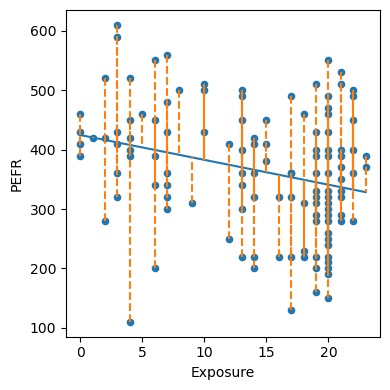

In [14]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted):
    ax.plot((x, x), (yactual,yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

# Multiple Linear Regression

## Example: King County Housing Data

The `head` method `pandas` data frame lists the top rows:

In [16]:
HOUSE_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\practical-statistics-for-data-scientists-master\practical-statistics-for-data-scientists-master\data\house_sales.csv"
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
house = pd.read_csv(HOUSE_CSV, sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


The goal is to predict the sales price from the other variables. `scikit-learn’s LinearRegression` can be used for multiple linear regression as well:

For a `LinearRegression` model, intercept and coefficients are the fields `intercept_` and `coef_` of the fitted model:

In [18]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -521871.368
Coefficients:
 SqFtTotLiving: 228.83060360240754
 SqFtLot: -0.06046682065306008
 Bathrooms: -19442.840398321146
 Bedrooms: -47769.955185214094
 BldgGrade: 106106.9630789811


## Assessing the model

The most _important performance metric_ from a data science perspective is `root mean squared error`, or `RMSE`. RMSE is the _square root of the average squared error_ in the predicted y(hat) values.

This _measures the overall accuracy of the model_ and is a basis for comparing it to other models (including models fit using machine learning techniques). Similar to RMSE is the residual standard error, or RSE. In this case we have p predictors, and the RSE is given by:

The only difference is that the denominator is the degrees of freedom, as opposed to number of records. In practice, for linear regression, the difference between RMSE and RSE is very small, particularly for big data applications.

`scikit-learn` provides a number of metrics for regression and classification. Here, we use `mean_squared_error` to get RMSE and `r2_score` for the coefficient of determination:

In [20]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 261220
r2: 0.5406


Use `statsmodels` to get a more detailed analysis of the regression model in _Python_:

In [22]:
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Thu, 28 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:09:59   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694

## Cross Validation

## Model Selection and Stepwise Regression

In _Python_, we need to convert the categorical and boolean variables into numbers:

In [25]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade', 'PropertyType', 'NbrLivingUnits', 'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True, dtype=int) 
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Thu, 28 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:10:00   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving                198.6364      4.234     46.920      0.000     190.338     206.934
SqFtLot                        0.0771      0.058      1.330      0.184      -0.037       0.191
Bathrooms                   4.286e+04   3808.114     11.255      0.000    3.54e+04    5.03e+04
Bedrooms                   -5.187e+04   2396.904    -21.638      0.000   -5.66e+04   -4.72e+04
BldgGrade                   1.373e+05   2441.242     56.228      0.000    1.32e+05    1.42e+05
NbrLivingUnits              5723.8438   1.76e+04      0.326      0.744   -2.87e+04    4.01e+04
SqFtFinBasement                7.0611      4.627      1.526      0.127      -2.009      16.131
YrBuilt                    -3574.2210     77.228    -46.282      0.000   -3725.593   -3422.849
YrRenovated                   -2.5311      3.924     -0.645      0.519     -10.222       5.160
NewConstruction            -2489.1122   5936.692     -0.419      0.675   -1.41e+04    9147.211
PropertyType_Single Family  2.997e+04   2.61e+04      1.149      0.251   -2.12e+04    8.11e+04
PropertyType_Townhouse      9.286e+04    2.7e+04      3.438      0.001    3.99e+04    1.46e+05
const                       6.182e+06   1.55e+05     39.902      0.000    5.88e+06    6.49e+06
==============================================================================
Omnibus:                    31006.128   Durbin-Watson:                   1.393
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26251977.078
Skew:                           7.427   Prob(JB):                         0.00
Kurtosis:                     168.984   Cond. No.                     2.98e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

`scikit-learn` has no implementation for stepwise regression. We implemented functions `stepwise_selection`, `forward_selection`, and `backward_elimination` in our `dmba` package:

In [27]:
y = house[outcome]

# 1 Define a function that returns a fitted model for a given set of variables

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

# 2 Define a function that returns a score for a given model and set of variables. 
#    In this case, we use the `AIC_score` implemented in the dmba package.

def score_model (model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df = 1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, verbose=True)

print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None
Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.2775530420158
 BldgGrade: 137159.5602261976
 YrBuilt: -3565.424939249463
 Bedrooms: -51947.38367361413
 Bathrooms: 42396.16452772056
 PropertyType_Townhouse: 84479.16203299937
 SqFtFinBasement: 7.046974967583083
 PropertyType_Single Family: 22912.05518701767


# Weighted Regression

Weighted regression is used by statisticians for a variety of purposes; in particular, it is important for analysis of complex surveys. Data scientists may find weighted regression useful in two cases:
- Inverse-variance weighting when different observations have been measured with different precision; the higher variance ones receiving lower weights.
- Analysis of data where rows represent multiple cases; the weight variable encodes how many original observations each row represents.

For example, with the housing data, older sales are less reliable than more recent sales. Using the `DocumentDate` to determine the year of the sale, we can compute `Weight` as the number of years since 2005 (the beginning of the data):

In [29]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))
house['Weight'] = house.Year - 2005

Most models in `scikit-learn` accept weights as the keyword argument `sample_weight` in the call of the fit method:

In [31]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight = house.Weight)

pd.concat([
    pd.DataFrame({
        'predictor': predictors,
        'house_lm': house_lm.coef_,
        'house_wt': house_wt.coef_,
    }),
    pd.DataFrame({
        'predictor': ['intercept'],
        'house_lm': house_lm.intercept_,
        'house_wt': house_wt.intercept_,
    })
])

,predictor,house_lm,house_wt
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
0,intercept,-521871.368188,-584189.329446


# Prediction Using Regression

## Confidence and Prediction Intervals

   abs_residual_lm  abs_residual_wt  Year
1    123750.814194    107108.553965  2014
2     59145.413089     96191.882094  2006
3    190108.725716    187004.492880  2007
4    198788.774412    196132.996857  2008
5     91774.996129     84277.577512  2013


,Year,mean abs_residual_lm,mean abs_residual_wt
0,2006,140540.303585,146557.454636
1,2007,147747.577959,152848.523235
2,2008,142086.905943,146360.411668
3,2009,147016.720883,151182.924825
4,2010,163267.674885,166364.476152
5,2011,169937.385744,172950.876028
6,2012,169506.670053,171874.424266
7,2013,203659.777510,206242.199403
8,2014,184452.840665,186668.573750
9,2015,172323.435147,169842.742053


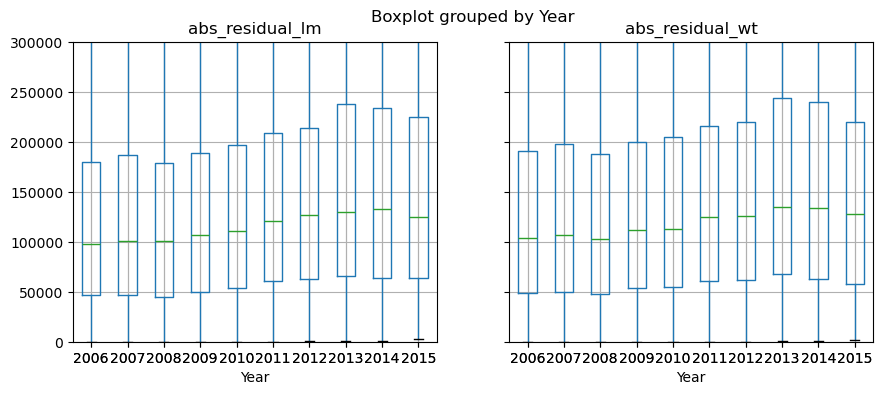

In [33]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())

axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10,4))
axes[0].set_ylim(0, 300000)

pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])]
             for year, group in residuals.groupby('Year')),
            columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])

#for year, group in residuals.groupby('Year'):
#    print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))


# Factor Variables in Regression

## Dummy Variables Representation

In the King County housing data, there is a factor variable for the property type; a small subset of six records is shown below:

In [35]:
house.PropertyType.head()

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object

To use the factor variable, we need to convert it to a set of binary variables. We do this by creating a binary variable for each possible value of the factor variable. In _Python_, we can convert categorical variables to dummies using the pandas method `get_dummies`:

In [37]:
# By default, returns one hot encoding (all factors levels are retained) 
# of the categorical variable.
pd.get_dummies(house['PropertyType']).head(6)



,Multiplex,Single Family,Townhouse
1,True,False,False
2,False,True,False
3,False,True,False
4,False,True,False
5,False,True,False
6,False,False,True


In [38]:
# drop_first argument will return P - 1 columns (to remove intercept term). 
# To avoid the problem of multicollinearity.
pd.get_dummies(house['PropertyType'], drop_first=True).head(6)

,Single Family,Townhouse
1,False,False
2,True,False
3,True,False
4,True,False
5,True,False
6,False,True


The method `get_dummies` takes the optional keyword argument `drop_first` to exclude the first factor (intercept term) as _reference_:

In [40]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.37362892503805
 SqFtLot: -0.07036798136812195
 Bathrooms: -15979.013473415263
 Bedrooms: -50889.73218483014
 BldgGrade: 109416.30516146208
 PropertyType_Single Family: -84678.21629549275
 PropertyType_Townhouse: -115121.97921609186


The coefficients are interpreted as relative to `Multiplex`, so a home that is `Single Family` is worth almost USD85,000 less, and a home that is `Townhouse` is worth over USD150,000 less.

Note: This is unintuitive, but can be explained by the impact of location as a confounding variable; see "Confounding Varibles."

# Factor Variables with Many Levels

Some factor variables can produce a huge number of binary dummies - zip codes are a factor variable. In such cases it is useful to explore the data, and the relationships between predictor variables and the outcome, to determine whether useful information is contained in the categories. If so, you must further decide whether it is useful to retain all factors, or whehter the levels should be consolidated.

The `value_counts` method of `pandas` data frames returns the same information:

In [43]:
print(pd.DataFrame(house['ZipCode'].value_counts()).transpose())

ZipCode  98038  98103  98042  98115  98117  98052  98034  98033  98059  98074  \
count      788    671    641    620    619    614    575    517    513    502   

ZipCode  ...  98051  98024  98354  98050  98057  98288  98224  98068  98113  \
count    ...     32     31      9      7      4      4      3      1      1   

ZipCode  98043  
count        1  

[1 rows x 80 columns]


Problem: If only several zip codes have only one sale and a df of 5, we need to have 79 coefficients corresponding to 79 degrees of freedom.

Solution:
- to consolidate a zip code using first 2 or 3 digits (submetropolitan geographic region)
- _alternative approach_ is to group the zip codes to another variable - sale price but even better is `residuals` from initial model.

In _Python_ we can calculate this information as follows:

In [45]:
house = pd.read_csv(HOUSE_CSV, sep='\t')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

ZipGroup
0    16
1    16
2    16
3    16
4    16
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_3244\1906284560.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: {


In [46]:
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

# Interpreting the Regression Equation

## Correlated Predictors

In [48]:
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.2775530420158
 BldgGrade: 137159.5602261976
 YrBuilt: -3565.424939249463
 Bedrooms: -51947.38367361413
 Bathrooms: 42396.16452772056
 PropertyType_Townhouse: 84479.16203299937
 SqFtFinBasement: 7.046974967583083
 PropertyType_Single Family: 22912.05518701767


In _Python_, there is no equivalent to _R's_ `update` function. We need to refit the model with the modified predictor list:

In [50]:
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])

print(f'Intercept: {reduced_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f' {name}: {coef}')

Intercept: 4913973.344
Coefficients:
 Bedrooms: 27150.537230219703
 BldgGrade: 248997.79366212635
 YrBuilt: -3211.7448621551157
 PropertyType_Single Family: -19898.495340501973
 PropertyType_Townhouse: -47355.436873344275


# Confounding Variables

The problem is one of _omission_ of an important variable is not included in the regression equation. _Naive interpretation_ of the equation coefficients can to _invalid conclusions._

To model location, include a variable `ZipGroup` that categorizes the zip code into one of five groups, from least expensive(1) to most (5).

In [52]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade',
             'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -666637.469
Coefficients:
 SqFtTotLiving: 210.61266005580134
 SqFtLot: 0.45498713854659023
 Bathrooms: 5928.425640001405
 Bedrooms: -41682.871840744636
 BldgGrade: 98541.18352726007
 PropertyType_Single Family: 19323.625287919374
 PropertyType_Townhouse: -78198.72092762377
 ZipGroup_1: 53317.17330659819
 ZipGroup_2: 116251.58883563553
 ZipGroup_3: 178360.5317879338
 ZipGroup_4: 338408.60185652046


# Interactions and Main Effects

In _Python_, we need to use the `statsmodels` package to train linear regression models with interactions. This package was designed similar to _R_ and allows defining models using a formula interface:

In [55]:
model = smf.ols(formula='AdjSalePrice ~ SqFtTotLiving*ZipGroup + SqFtLot + ' + 
               'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3247.
Date:                Thu, 28 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:10:02   Log-Likelihood:            -3.1098e+05
No. Observations:               22687   AIC:                         6.220e+05
Df Residuals:                   22671   BIC:                         6.221e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

# Regression Diagnostics

# Outliers

Let's fit a regression to King County house sales data for all sales in zip code 98105 in _Python_:

In [57]:
house_98105 = house.loc[house['ZipCode'] == 98105, ]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome],
                      house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()
print(result_98105.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Thu, 28 Nov 2024   Prob (F-statistic):          1.69e-103
Time:                        17:10:02   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587

In `statsmodels`, use `OLSInfluence` to analyze the residuals:

In [59]:
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal
sresiduals.idxmin(), sresiduals.min()

(24333, -4.326731804078564)

In [60]:
print(result_98105.resid.loc[sresiduals.idxmin()])

-757753.6192115829


In [61]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


# Influential Values

An _influential plot_ or _bubble plot_ combines standardized residuals, the hat-value, and Cook's distance in a single plot.

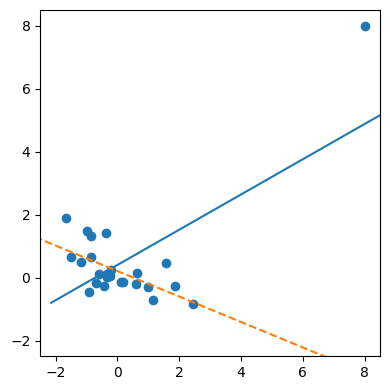

In [63]:
%matplotlib inline
from scipy.stats import linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
x[0] = 8
y[0] = 8

def abline(slope, intercept, ax):
    # Calculate coordinates of a line based on slope and intercept
    x_vals = np.array(ax.get_xlim())
    return(x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x,y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'studentized residuals')

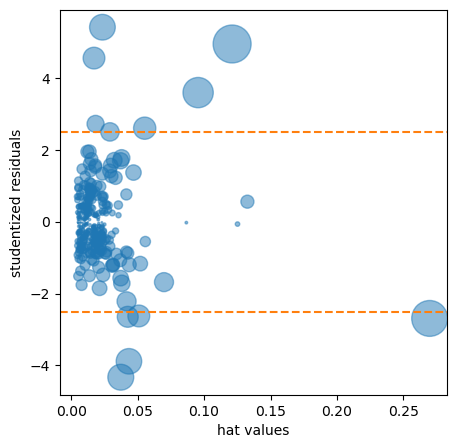

In [64]:
influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5,5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal,
          s=1000 * np.sqrt(influence.cooks_distance[0]),
          alpha=0.5)
ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

In [65]:
# Table 4-2
mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

,Original,Influential removed
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


# Heteroskedasticity, Non-Normality, and Correlated Errors

In _Python_, the `seaborn` package has the `regplot` function to plot the absolute residuals versus the predicted values for lm_98105 regression fit in "Outliers"

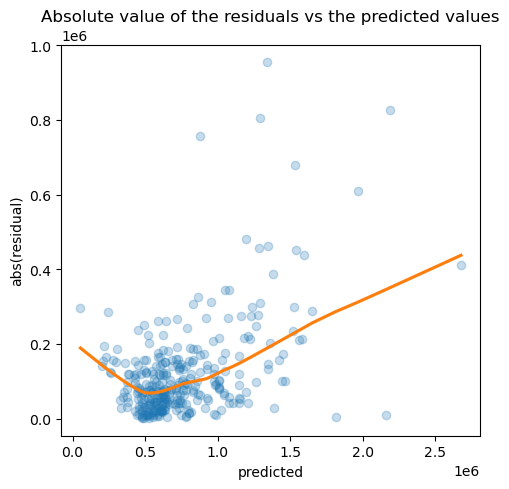

In [67]:
fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid),
           scatter_kws={'alpha': 0.25}, line_kws={'color': 'C1'},
           lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')
ax.set_title('Absolute value of the residuals vs the predicted values')

plt.tight_layout()
plt.show()

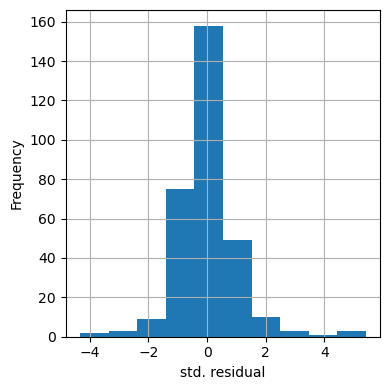

In [68]:
fig, ax = plt.subplots(figsize=(4,4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Partial Residual Plots and Nonlinearity

The partial residual plot displays the _X(sub i)_ on the x-axis and the partial residuals on the y-axis. The `statsmodels` package has the method `sm.graphics.plot_ccpr` that create a similar partial residual plot:

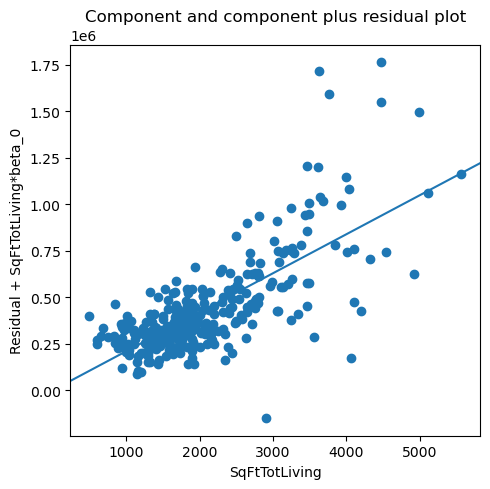

In [70]:
fig, ax = plt.subplots(figsize=(5,5))
fig = sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving', ax=ax)

plt.tight_layout()
plt.show()

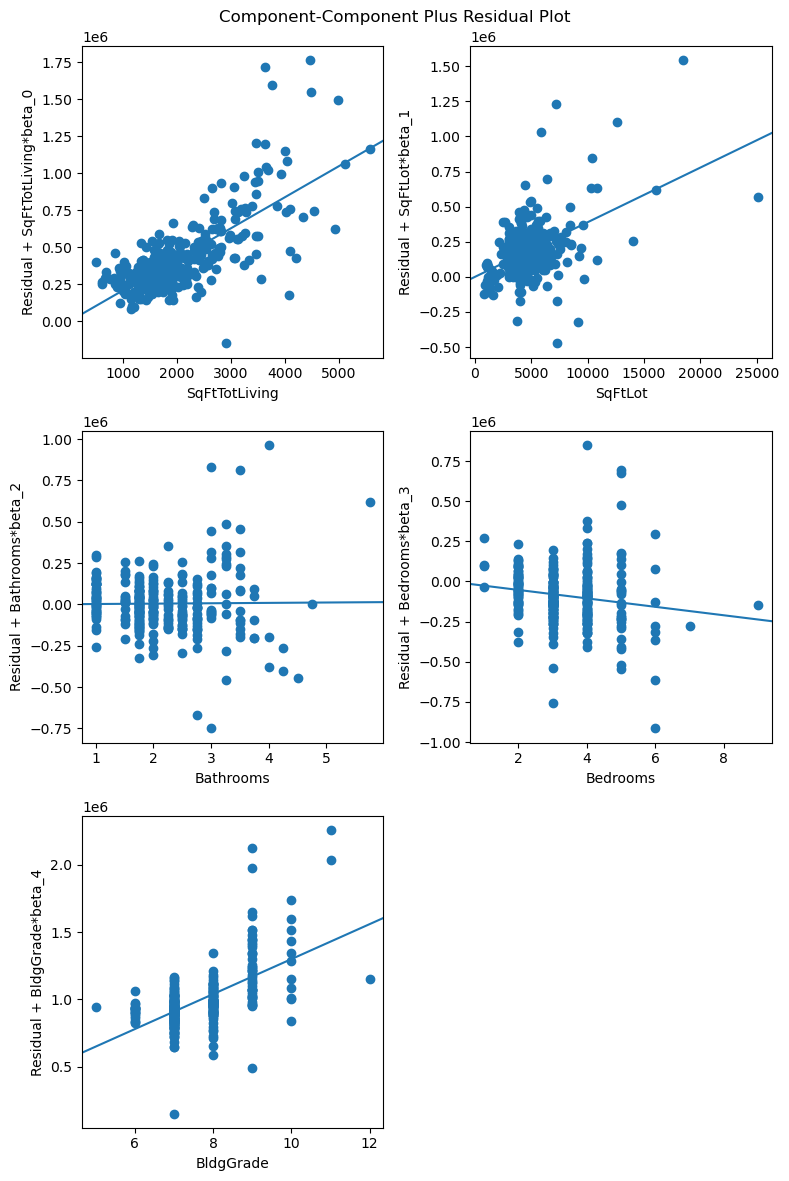

In [71]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

# Polynomial and Spline Regression

# Polynomial
_Polynomial regression_ involves including polynomial terms in a regression equation. In `statsmodels`, we add the squared term to the model definition using `I(SqFtTotLiving**2):`

In [73]:
model_poly = smf.ols(formula='AdjSalePrice ~ SqFtTotLiving + ' + 
                     '+ I(SqFtTotLiving**2) + ' + 
                     'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()

# 1 - The intercept and the polynomial coefficients are different compared to R.
# This is due to different implementations. The remaining coefficients and the 
# predictions are equivalent.
result_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Thu, 28 Nov 2024   Prob (F-statistic):          9.95e-106
Time:                        17:10:04   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -6.159e+05   1.03e+05     -5.953      0.000   -8.19e+05   -4.12e+05
SqFtTotLiving             7.4521     55.418      0.134      0.893    -101.597     116.501
I(SqFtTotLiving ** 2)     0.0388      0.010      4.040      0.000       0.020       0.058
SqFtLot                  32.5594      5.436      5.990      0.000      21.863      43.256
Bathrooms             -1435.1231   1.95e+04     -0.074      0.941   -3.99e+04     3.7e+04
Bedrooms              -9191.9441   1.33e+04     -0.693      0.489   -3.53e+04    1.69e+04
BldgGrade              1.357e+05   1.49e+04      9.087      0.000    1.06e+05    1.65e+05
==============================================================================
Omnibus:                       75.161   Durbin-Watson:                   1.625
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              637.978
Skew:                           0.699   Prob(JB):                    2.92e-139
Kurtosis:                       9.853   Cond. No.                     7.37e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.37e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The `statsmodels` implementation of a partial residual plot works only for linear term. Here is an implementation of a partial residual plot that, while inefficient, works for the polynomial regression.

C:\Users\User\AppData\Local\Temp\ipykernel_3244\2555558784.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'ypartial': feature_prediction - model.params[0],


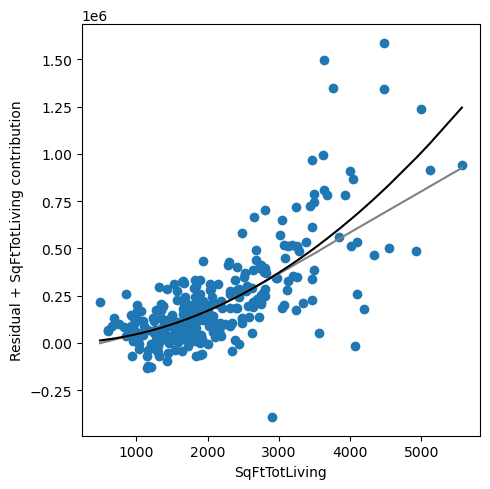

0.038791281682372


C:\Users\User\AppData\Local\Temp\ipykernel_3244\2555558784.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(result_poly.params[2])


In [75]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])

# Splines

The `statsmodels` formula interface supports the use of splines in a similar way to _R_. Here, we specify the _b-spline_ using `df`, the degrees of freedom. This will create `df - degree = 6 - 3 = 3` internal knows with position calculated in the same way as in the _R_ code:

In [78]:
formula = 'AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + 'SqFtLot + Bathrooms + Bedrooms + BldgGrade'
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Thu, 28 Nov 2024   Prob (F-statistic):          7.10e-104
Time:                        17:10:04   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_3244\2555558784.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'ypartial': feature_prediction - model.params[0],


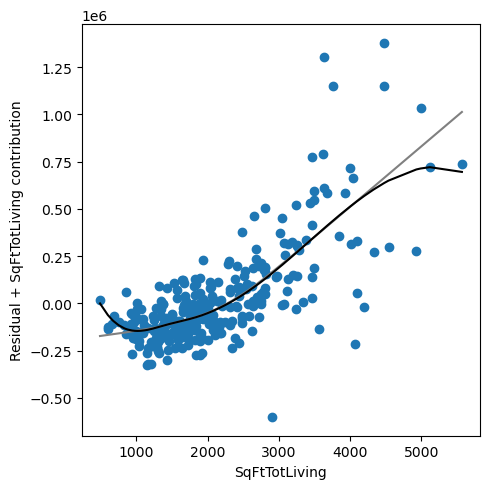

In [79]:
fig, ax = plt.subplots(figsize=(5,5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()

# Generalized Additive Models

In [81]:
from statsmodels.gam.api import GLMGam, BSplines

In [82]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

x_spline = house_98105[predictors]
bs = BSplines(x_spline, df=[10]+[3]*4, degree=[3]+[2]*4)

# penalization weight
alpha = np.array([0] * 5)

formula = ('AdjSalePrice ~ SqFtTotLiving + ' + 'SqFtLot + Bathrooms + Bedrooms + BldgGrade')

gam_sm = GLMGam.from_formula(formula, data=house_98105, smoother=bs,
                            alpha=alpha)
res_sm = gam_sm.fit()
print(res_sm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           AdjSalePrice   No. Observations:                  313
Model:                         GLMGam   Df Residuals:                   295.00
Model Family:                Gaussian   Df Model:                        17.00
Link Function:               Identity   Scale:                      2.7471e+10
Method:                         PIRLS   Log-Likelihood:                -4196.6
Date:                Thu, 28 Nov 2024   Deviance:                   8.1039e+12
Time:                        17:10:05   Pearson chi2:                 8.10e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9901
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.481e+05   1.18e+05  

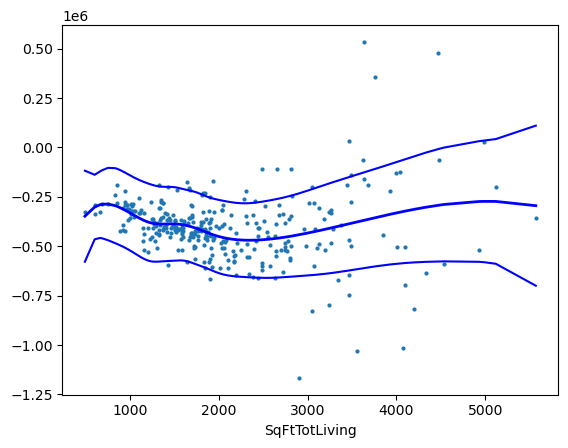

In [83]:
res_sm.plot_partial(0, cpr=True);

In _Python_, we can use the `pyGAM` package. It provides methods for regression and classification. Here, we use `LinearGAM` to create the regression model:

In [85]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

X = house_98105[predictors].values
y = house_98105[outcome]

# model
# the default value for `n_splines` is 20. This leads to overfitting for larger 
# SqFtTotLiving values. A value of 12 leads to a more reasonable fit.
gam = LinearGAM(s(0, n_splines=12)+l(1)+l(2)+l(3)+l(4))
gam.gridsearch(X, y)
print(gam.summary())

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6772
Link Function:                     IdentityLink Log Likelihood:                                 -7833.1159
Number of Samples:                          313 AIC:                                            15683.5863
                                                AICc:                                             15684.14
                                                GCV:                                      30838885095.1705
                                                Scale:                                     29480381715.832
                                                Pseudo R-Squared:                                   0.8117
Feature Function                  Lam

C:\Users\User\AppData\Local\Temp\ipykernel_3244\87384639.py:12: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


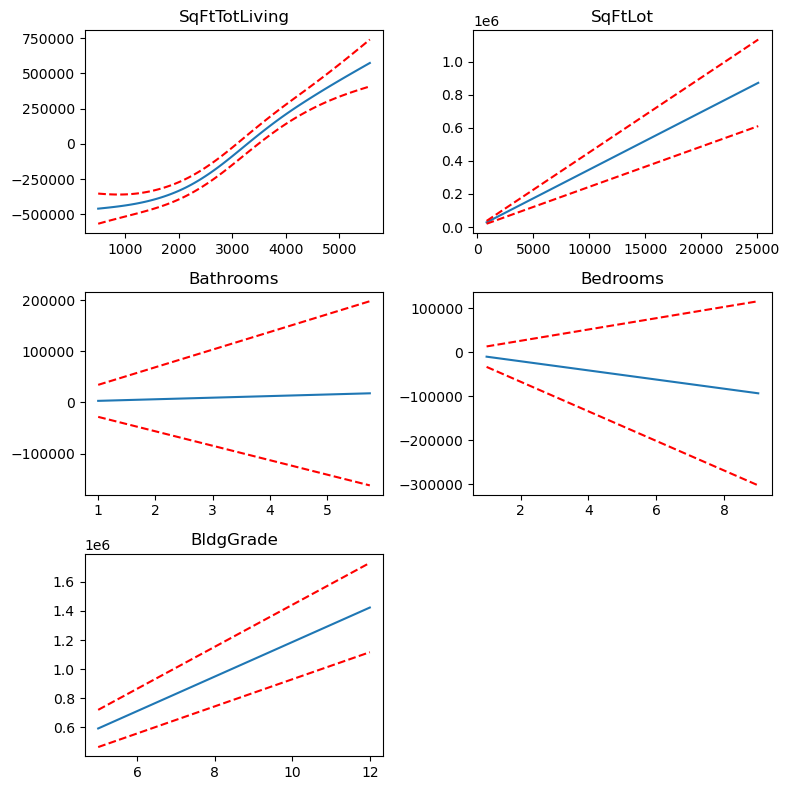

In [86]:
fig, axes = plt.subplots(figsize=(8,8), ncols=2, nrows=3)

titles = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
for i, title in enumerate(titles):
    ax = axes[i // 2, i % 2]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', 
            ls='--')
    ax.set_title(titles[i])

axes[2][1].set_visible(False)

plt.tight_layout()
plt.show()

# Regularization

# Lasso

In [88]:
from sklearn.linear_model import Lasso, LassoLars, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler

In [89]:
HOUSE_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\house_sales.csv"
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms',
         'Bedrooms', 'BldgGrade']

house = pd.read_csv(HOUSE_CSV, sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [90]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade', 'PropertyType', 
              'NbrLivingUnits', 'SqFtFinBasement', 'YrBuilt', 
              'YrRenovated', 'NewConstruction']
outcome = 'AdjSalePrice'

X= pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]
columns = X.columns

y = house[outcome]

house_lm = LinearRegression()
print(house_lm.fit(X, y))

LinearRegression()


In [91]:
house_lasso = Lasso(alpha=10)
print(house_lasso.fit(X, y))

Lasso(alpha=10)


In [ ]:
Method = LassoLars
MethodCV = LassoLarsCV
Method = Lasso
MethodCV = LassoCV

alpha_values = []
results = []
for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 
              1000, 10000, 100000, 1000000, 10000000]:
    model = Method(alpha=alpha)
    model.fit(X, y)
    alpha_values.append(alpha)
    results.append(model.coef_)

modelCV = MethodCV(cv=5)
modelCV.fit(X, y)
ax = pd.DataFrame(results, index=alpha_values, columns=columns).plot(logx=True, legend=False)
ax.axvline(modelCV.alpha_)
plt.show()

In [ ]:
pd.DataFrame({
    'name': columns,
    'coef': modelCV.coef_,
})